Load data from files

In [2]:
import os
import json
import nltk
import pandas as pd


def getquestions():
    # data location
    question_dir = 'STEMquestions/data/'

    # list to store the extracted questions
    questions = []

    # Walk through the base directory and its subfolders
    for root, dirs, files in os.walk(question_dir):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                
                # Open and read the JSON file
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    
                    # Extract the 'Original question' and add to the list
                    if "Original question" in data:
                        questions.append(data["Original question"])

    df = pd.read_parquet("hf://datasets/TIGER-Lab/TheoremQA/data/test-00000-of-00001.parquet")
    questions += df['Question'].tolist()

    return questions

def getsentences(num_sentences):
    # Ensure you have the Punkt tokenizer models for sentence splitting (if not done already)
    # nltk.download('punkt')

    from nltk.tokenize import sent_tokenize

    # Define the base directory where your text files are located
    base_dir = 'STEMtext/'

    # Initialize a list to store the sentence chunks
    sentence_chunks = []

    # Number of sentences to extract
    sentences_per_chunk = 3  # Number of sentences per chunk (adjust as needed)

    # Loop through the text files in the directory
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                
                # Open and read the content of the text file
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    
                    # Tokenize the content into individual sentences
                    sentences = sent_tokenize(content)
                    
                    # Group the sentences into chunks of sentences_per_chunk size
                    for i in range(0, len(sentences), sentences_per_chunk):
                        chunk = " ".join(sentences[i:i + sentences_per_chunk])
                        sentence_chunks.append(chunk)
                        
                        # Stop if we have collected enough sentence chunks
                        if len(sentence_chunks) >= num_sentences:
                            break

                # Stop outer loop if we have enough sentence chunks
                if len(sentence_chunks) >= num_sentences:
                    break

    return sentence_chunks
   

questions = getquestions()
sentences = getsentences(len(questions))
print(questions[0])
print(sentences[0])
print(len(questions), len(sentences))

c:\Users\jkamp\AppData\Local\pypoetry\Cache\virtualenvs\purdueprep-TEZ28JzX-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Determine the kind of nonmarine sedimentary deposits that reflects arid environmental conditions
Integrality of the Chern character in small codimension

Abstract
We prove an integrality property of the Chern character with values in Chow groups. As a consequence, we obtain a construction of the p-1 first homological Steenrod operations on Chow groups modulo p and p-primary torsion, over an arbitrary field. We provide applications to the study of correspondences between algebraic varieties.
1467 1467


Encode sentences as vectors and create labels

In [3]:
from sentence_transformers import SentenceTransformer
import pandas as pd

def vector_encode(strings):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    return model.encode(strings)

text = questions + sentences

embeddings = vector_encode(text)

labels = [1] * len(questions) + [0] * len(sentences)

df = pd.DataFrame(embeddings)
df['label'] = labels

c:\Users\jkamp\AppData\Local\pypoetry\Cache\virtualenvs\purdueprep-TEZ28JzX-py3.12\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Train model

Test Accuracy: 0.9574105621805792


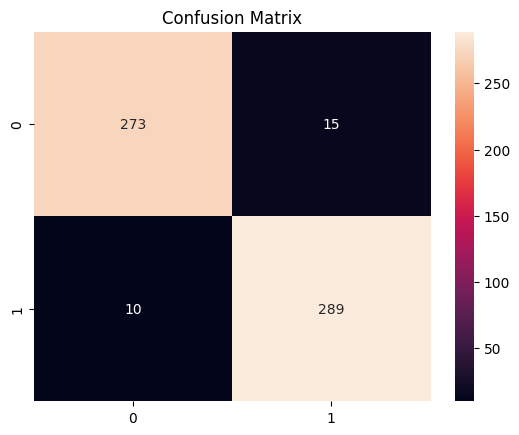

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       288
           1       0.95      0.97      0.96       299

    accuracy                           0.96       587
   macro avg       0.96      0.96      0.96       587
weighted avg       0.96      0.96      0.96       587



In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Split the data into training and test sets
X = df.drop('label', axis=1)
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize XGBoost model
model = xgb.XGBClassifier(eval_metric='mlogloss')

# Train the model with validation set
model.fit(
    X_train, y_train,
)


# Accuracy
y_pred = model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


Save model

In [8]:
import pickle
with open('questionid.pkl', 'wb') as f:
    pickle.dump(model, f)

test on new sentences

In [9]:
import numpy as np

test_sentences = getsentences(4000)[2000:4000]
test_sentences_enc = vector_encode(test_sentences)

c:\Users\jkamp\AppData\Local\pypoetry\Cache\virtualenvs\purdueprep-TEZ28JzX-py3.12\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
pred = model.predict(test_sentences_enc[0])
print(pred)

XGBoostError: [14:17:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\predictor\cpu_predictor.cc:789: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 384) : Number of columns in data must equal to trained model.

In [10]:
preds = model.predict(test_sentences_enc)
print(preds.tolist().count(0)/len(preds))

0.8415
